In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA, NMF
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from pca import pca

In [2]:
#functions

def scale(X):
    """ function to scale the feature matrix """
    scalar = StandardScaler()
    scalar = scalar.fit(X)
    X = scalar.transform(X)
    return X


def classify3(text):
    """ function to create lung cancer classes based on histology description"""
    if 'Squamous Cell Carcinoma' in text:
        result = "Squamous Cell Carcinoma"
    elif 'Adenocarcinoma' in text:
        result = "Adenocarcinoma"
    else: result = "Other"
    return result


def plot_sub_cluster(X, df):
    """ function to plot a scatter plot of first two dimensions of feature matrix X """
    #add x and y to original dataframe and use class for hue
    df['x'] = X[:,0]
    df['y'] = X[:,1]
    ax = sns.scatterplot(x = 'x', y = 'y', hue = 'class', data = df, 
                         legend = False, alpha = 0.5, palette=['red', 'blue'])
    return ax



def inertia_list(X):
    """ function that creates an inertia list, to be used for elbow plot"""
    km_list = list()
    for clust in range(1,25):
        km = KMeans(n_clusters=clust, random_state=2)
        km = km.fit(X)

    
        km_list.append(pd.Series({'clusters': clust, 
                                  'inertia': km.inertia_,
                                  'model': km}))
    return km_list



# Load the data

In [3]:
gene = pd.read_csv('data/GSE58661_series_matrix.txt', header=61, sep='\t', quotechar='"')
df = pd.read_excel('data/Lung3.metadata.xls') #load metadata

## Inspect the data

In [4]:
#inspect for skewness, the genes are presented in rows
gene.skew(axis=0).describe()

/var/folders/26/5fcsf8bs6lvdrmys57ttrlv80000gn/T/ipykernel_37383/4084494182.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gene.skew(axis=0).describe()


count    89.000000
mean      0.442307
std       0.025409
min       0.396689
25%       0.426808
50%       0.441002
75%       0.453303
max       0.587398
dtype: float64

The data is not highly skewed. This is problably due to the applied RMA algorithm that processed the raw data which does background correction, normalization, quantile normalization, probe level intensity calculation and log (base 2) scale correction. Therefor it is decided no log conversion is needed. 

In [5]:
df['characteristics.tag.histology'].value_counts()

Squamous Cell Carcinoma, NOS                                            33
Adenocarcinoma, NOS                                                     25
Non-Small Cell                                                           7
Adenocarcinoma, Papillary, NOS                                           4
Adenocarcinoma, Bronchiolo-alveolar Features                             4
Adenocarcinoma, Acinar Type                                              3
Solid Type And Acinar                                                    2
Adenocarcinoma With Papillary Features                                   2
Adenocarcinoma, Mixed                                                    1
Adenocarcinoma, Mucinous With Bronchiolo-alveolar Features               1
Squamous Cell Carcinoma, Other (Specify) with adeno features             1
Adenocarcinoma With Mucinous Features                                    1
Papillary Type AND      Adenocarcinoma, Bronchiolo-alveolar Features     1
Carcinoma, Large Cell, Ne

The clinical data is unbalanced. Some classes have only 1 sample. The classes are recategorized into three groups, only Squamous Cell Carcinoma and Adenocarcinoma are selected for further analysis

## Clean the data

In [6]:
#only use the two large classes
df['class'] = df['characteristics.tag.histology'].apply(classify3) 
df = df[df['class'].isin(['Adenocarcinoma', 'Squamous Cell Carcinoma'])]
indexes = df.index.to_list()

From a biological perspective we are only interested in genes that are highly expressed. Therefor only genes with expression values more then the .75 quantile will be used

In [7]:
#clean last row
gene = gene.set_index('ID_REF').T.drop('!series_matrix_table_end', axis=1)
# only take 75% highest expressed genes
subset_genes = gene[gene > np.quantile(gene, .75)]  
to_drop = []
for i in subset_genes.columns:
    if subset_genes[i].isna().sum() == len(gene):
        to_drop.append(i)
                
gene = gene.drop(to_drop, axis=1)

In [8]:
skew_columns = (gene.skew().sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

ID_REF
merck-NC_001526_ORF_1178_at    9.014309
merck-NC_001526_ORF_1180_at    8.944469
merck-NC_001526_ORF_1182_at    8.699111
merck-BX648957_at              8.601416
merck-NC_001526_ORF_1179_at    8.505894
                                 ...   
merck-NM_018938_at             0.751118
merck2-BC065305_at             0.750838
merck-NM_003567_at             0.750836
merck2-ENST00000342827_s_at    0.750644
merck2-NM_005087_at            0.750531
Length: 5011, dtype: float64

In [9]:
#create matrix X
data = gene.copy()
#get data of the two cancer classes
data = data.iloc[indexes]
#scale the data
X = scale(data)
#make y numeric
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['class'])

# Dimension reduction

PCA is used to check how many components explain the variance. 

## PCA

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [89.5%] explained variance using the [28967] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [50] that covers the [89.50%] explained variance.
[pca] >The PCA reduction is performed on the [28967] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[50]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


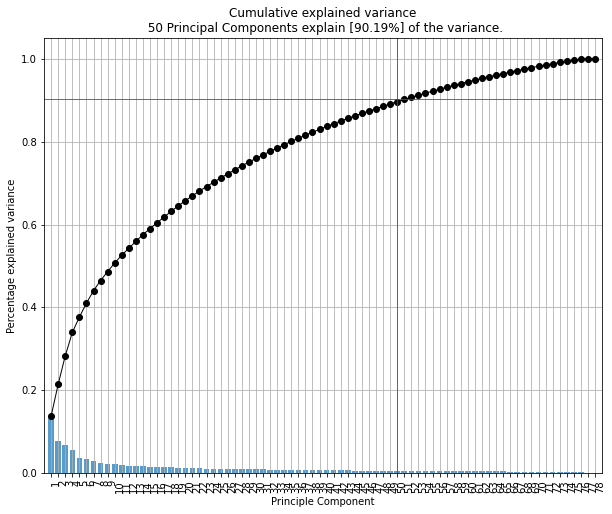

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 50 Principal Components explain [90.19%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [10]:
pca_model = pca(n_components=0.895, normalize=False)
results = pca_model.fit_transform(X)
pca_model.plot(figsize=(10,8))

50 components explain 90% of the variance

In [11]:
print(f'original X: {X.shape}')
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)
print(f'reduced by pca: {X_pca.shape}')

original X: (78, 28967)
reduced by pca: (78, 50)


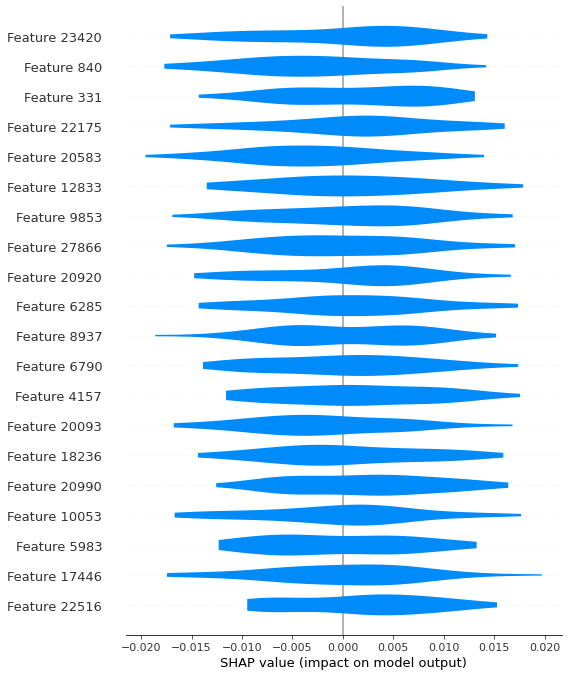

In [12]:
import shap 
loadings = pd.DataFrame(pca.components_, columns=gene.columns)
shap_values = pca.components_
# Violin plot
shap.summary_plot(shap_values, plot_type='violin')

## kernel PCA

In [13]:
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
  ])
param_grid = [{"kpca__gamma": np.linspace(0.0, 1, 100), 
               "kpca__kernel":["rbf", "sigmoid", "poly"]}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'kpca__gamma': 0.010101010101010102, 'kpca__kernel': 'sigmoid'}


In [14]:
print(f'original X: {X.shape}')
kernel_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.01, n_jobs=2)
X_kernel_pca = kernel_pca.fit_transform(X)
print(f'reduced by kernel PCA: {X_kernel_pca.shape}')


original X: (78, 28967)
reduced by kernel PCA: (78, 2)


## tsne

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
The PCA initializati

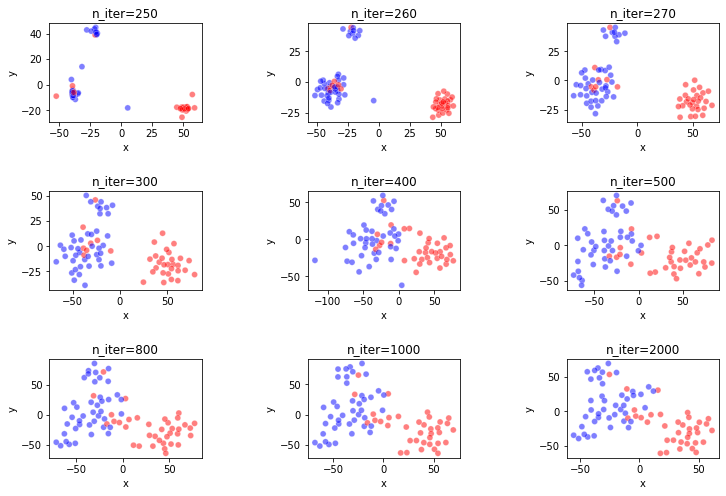

In [15]:
p = [250, 260, 270, 300, 400, 500, 800, 1000, 2000]
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.7)

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    X_embedded = TSNE(learning_rate='auto', init='pca', 
                      perplexity = 8, 
                      random_state = 42,
                      n_iter = p[i])
    X_embedded = X_embedded.fit_transform(X)
    plot_sub_cluster(X_embedded, df)
    ax.set_title(f'n_iter={p[i]}')
plt.show()

In [16]:
print(f'original X: {X.shape}')
tsne = TSNE(verbose=1, perplexity=8, n_iter= 800, random_state=42, learning_rate='auto', init='pca')
X_tsne = tsne.fit_transform(X)
print(f'reduced by tsne: {X_tsne.shape}')

original X: (78, 28967)
[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 78 samples in 0.001s...
[t-SNE] Computed neighbors for 78 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 78 / 78
[t-SNE] Mean sigma: 52.636345


The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.316666
[t-SNE] KL divergence after 800 iterations: 0.677116
reduced by tsne: (78, 2)


## nmf

In [17]:
model = NMF(n_components=2, init='random')
X_nmf = model.fit_transform(data)

Maximum number of iterations 200 reached. Increase it to improve convergence.


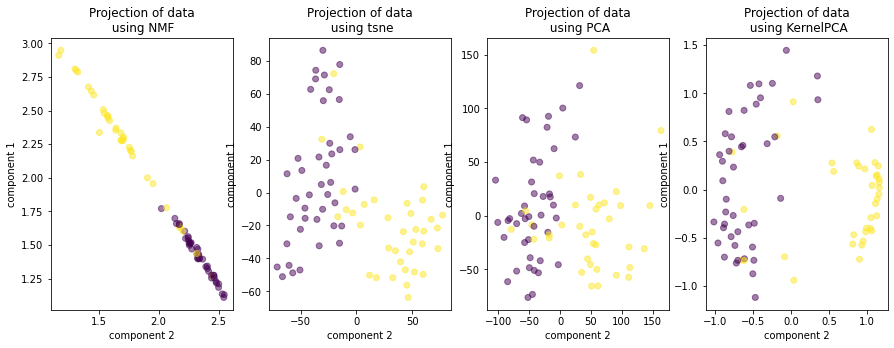

In [18]:
fig, (nmf_proj_ax, tsne_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=4, figsize=(15,5 )
)

nmf_proj_ax.scatter(X_nmf[:, 0], X_nmf[:, 1], c=y, alpha = 0.5)
nmf_proj_ax.set_ylabel("component 1")
nmf_proj_ax.set_xlabel("component 2")
nmf_proj_ax.set_title("Projection of data\n using NMF")

tsne_data_ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, alpha = 0.5)
tsne_data_ax.set_ylabel("component 1")
tsne_data_ax.set_xlabel("component 2")
tsne_data_ax.set_title("Projection of data\n using tsne")

pca_proj_ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha = 0.5)
pca_proj_ax.set_ylabel("component 1")
pca_proj_ax.set_xlabel("component 2")
pca_proj_ax.set_title("Projection of data\n using PCA")

kernel_pca_proj_ax.scatter(X_kernel_pca[:, 0], X_kernel_pca[:, 1], c=y, alpha = 0.5)
kernel_pca_proj_ax.set_ylabel("component 1")
kernel_pca_proj_ax.set_xlabel("component 2")
_ = kernel_pca_proj_ax.set_title("Projection of data\n using KernelPCA")

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


Text(0.5, 1.0, 'elbow curve Kmeans using tsne components')

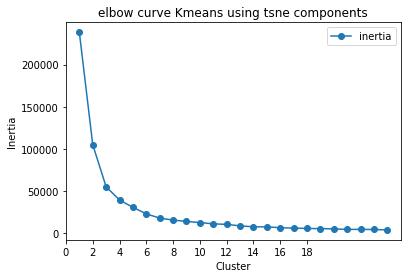

In [19]:
km_list = inertia_list(X_tsne)
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,20,2))
ax.set_xlim(0,25)
ax.set(xlabel='Cluster', ylabel='Inertia');
ax.set_title('elbow curve Kmeans using tsne components')

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


Text(0.5, 1.0, 'elbow curve Kmeans using original data')

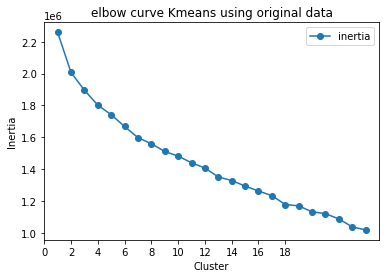

In [20]:
km_list = inertia_list(X)
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,20,2))
ax.set_xlim(0,25)
ax.set(xlabel='Cluster', ylabel='Inertia');
ax.set_title('elbow curve Kmeans using original data')

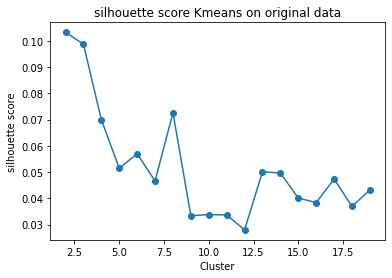

maximum silhouette score for k-means original data: 0.1033


In [37]:
from sklearn.metrics import silhouette_score
silhouette = []
list_num_clusters = list(range(2,20))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    silhouette.append(silhouette_score(X, km.labels_, metric='euclidean'))
    
plt.plot(list_num_clusters,silhouette)
plt.scatter(list_num_clusters,silhouette)
plt.xlabel('Cluster')
plt.ylabel('silhouette score')
plt.title('silhouette score Kmeans on original data')
plt.show()

print(f'maximum silhouette score for k-means original data: {silhouette[np.argmax(silhouette)]:.4f}')

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


Text(0.5, 1.0, 'elbow curve Kmeans using kernel pca components')

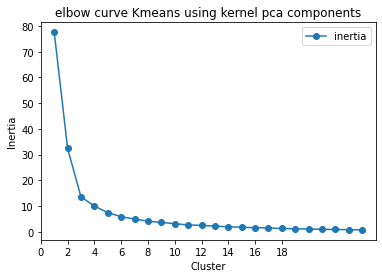

In [22]:
km_list = inertia_list(X_kernel_pca)
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,20,2))
ax.set_xlim(0,25)
ax.set(xlabel='Cluster', ylabel='Inertia');
ax.set_title('elbow curve Kmeans using kernel pca components')

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


Text(0.5, 1.0, 'elbow curve Kmeans using pca components')

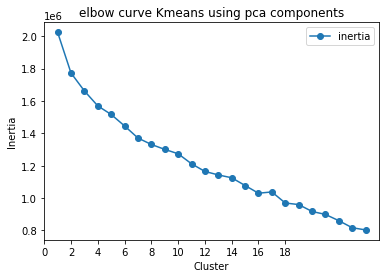

In [23]:
km_list = inertia_list(X_pca)
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,20,2))
ax.set_xlim(0,25)
ax.set(xlabel='Cluster', ylabel='Inertia');
ax.set_title('elbow curve Kmeans using pca components')

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


Text(0.5, 1.0, 'elbow curve Kmeans using NMF components')

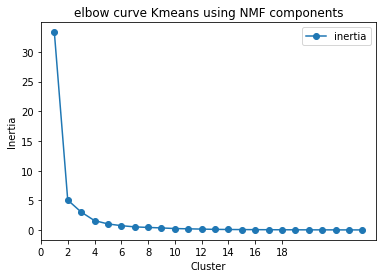

In [24]:
km_list = inertia_list(X_nmf)
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,20,2))
ax.set_xlim(0,25)
ax.set(xlabel='Cluster', ylabel='Inertia');
ax.set_title('elbow curve Kmeans using NMF components')

In [45]:
grid = {'n_clusters': [2],
       "init" : ["k-means++", "random"],
       "n_init": np.arange(1,15,1),
       "max_iter": np.arange(1,200,10)}
kmeans = KMeans()
kmeans_clf = GridSearchCV(kmeans, grid)
kmeans_clf.fit(X_tsne)
kmeans_clf.best_params_

{'init': 'k-means++', 'max_iter': 1, 'n_clusters': 2, 'n_init': 4}

In [48]:
from sklearn import metrics

km = KMeans(n_clusters=2)
km = km.fit(X_tsne)
kY = km.fit_predict(X_tsne)

metrics.adjusted_rand_score(kY, df['class'])

0.627215849843587

In [49]:
km = KMeans(n_clusters=2)
km = km.fit(X_nmf)
kY = km.fit_predict(X_nmf)

metrics.adjusted_rand_score(kY, df['class'])

0.6691217207104448

In [28]:
grid = {'n_clusters': [2],
       "init" : ["k-means++", "random"],
       "n_init": np.arange(1,15,1),
       "max_iter": np.arange(1,200,10)}
kmeans = KMeans()
kmeans_clf = GridSearchCV(kmeans, grid)
kmeans_clf.fit(X_kernel_pca)
kmeans_clf.best_params_

{'init': 'k-means++', 'max_iter': 1, 'n_clusters': 2, 'n_init': 2}

In [51]:

km = KMeans(n_clusters=2)
km = km.fit(X_kernel_pca)
kY = km.fit_predict(X_kernel_pca)

metrics.adjusted_rand_score(kY, df['class'])

0.5472492271017246

In [55]:
km = KMeans(n_clusters=2)
km = km.fit(X)
kY = km.fit_predict(X)

metrics.adjusted_rand_score(kY, df['class'])

0.627215849843587

In [56]:
grid = {'n_clusters': [50],
       "init" : ["k-means++", "random"],
       "n_init": np.arange(1,15,1),
       "max_iter": np.arange(1,200,10)}
kmeans = KMeans()
kmeans_clf = GridSearchCV(kmeans, grid)
kmeans_clf.fit(X_pca)
kmeans_clf.best_params_

{'init': 'random', 'max_iter': 61, 'n_clusters': 50, 'n_init': 9}

In [54]:
km = KMeans(n_clusters=2)
km = km.fit(X_pca)
kY = km.fit_predict(X_pca)

metrics.adjusted_rand_score(kY, df['class'])

0.5472492271017246